In [ ]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from keras import backend as K
import tensorflow.compat.v1 as tf1 
from tensorflow.python.framework import ops 
tf.compat.v1.disable_eager_execution()

model = load_model('/content/drive/MyDrive/models/CNN_Modelfinal.h5') 

img_size = (64, 64)
mapping = {0:'normal', 1:'bacteria', 2:'viral', 3:'COVID-19'}

mapping={0:'Apple Black rot' ,1:'Apple Cedar rust', 2:'Apple healthy' ,3:'Apple scab',
 4:'Blueberry healthy', 5:'Cherry Powdery mildew', 6:'Cherry healthy',
 7:'Corn Cercospora Gray leaf spot', 8:'Corn Common rust',
 9:'Corn Northern Leaf Blight', 10:'Corn healthy' ,11:'Grape Black rot',
 12:'Grape Esca Black Measles' ,13:'Grape Leaf blight Isariopsis Leaf Spot',
 14:'Grape healthy', 15:'Orange Haunglongbing Citrus greening',
 16:'Peach Bacterial spot', 17:'Peach healthy', 18:'Pepper bell Bacterial spot',
 19:'Pepper bell healthy', 20:'Potato Early blight', 21:'Potato Late blight',
 22:'Potato healthy' ,23:'Raspberry healthy' ,24:'Soybean healthy',
 25:'Squash Powdery mildew', 26:'Strawberry Leaf scorch', 27:'Strawberry healthy',
 28:'Tomato Bacterial spot', 29:'Tomato Early blight', 30:'Tomato Late blight',
 31:'Tomato Leaf Mold', 32:'Tomato Septoria leaf spot', 33:'Tomato Target Spot',
 34:'Tomato Two spotted spider mite', 35:'Tomato Yellow Leaf Curl Virus',
 36:'Tomato healthy', 37:'Tomato mosaic virus'}
 
last_conv_layer_name = "dropout_6" 
img_path="/content/drive/MyDrive/train/Apple Black rot/00e909aa-e3ae-4558-9961-336bb0f35db3___JR_FrgE.S 8593.JPG"

def load_image(path, preprocess=True):
    img_temp = cv2.imread(path)
    img_temp = cv2.resize(img_temp, img_size)
    img_temp = img_temp.astype('float32') / 255.0 
    if preprocess:
        img_temp= np.array(img_temp)
        img_temp = np.expand_dims(img_temp, axis=0)
    return img_temp

def deprocess_image(x):
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255 #to convert into RGB
    if K.image_data_format() == 'th': #to convert type 'th' to type 'tf'
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x
"""Function returning modified model.    
Changes gradient function for all ReLu activations
according to Guided Backpropagation.
"""
def build_guided_model():
    if "GuidedBackProp" not in ops._gradient_registry._registry: #avoid over-write
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf1.cast(grad > 0., dtype) * \
                   tf1.cast(op.inputs[0] > 0., dtype)

    g = tf1.get_default_graph()       #guidedbackdrop in another copy
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = load_model('/content/drive/MyDrive/models/CNN_Modelfinal.h5')
    return new_model

#Guided Backpropagation method
def guided_backprop(input_model, images, layer_name): 
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val


In [ ]:
#GradCAM method
def grad_cam(input_model, image, cls, layer_name): 
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, img_size, cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Model prediction: Apple Black rot

Probabilities:
	0. Apple Black rot	1.000
	1. Apple Cedar rust	0.000
	2. Apple healthy	0.000
	3. Apple scab	0.000

Explanation for 'Apple Black rot':



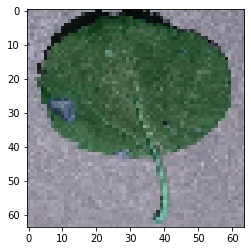

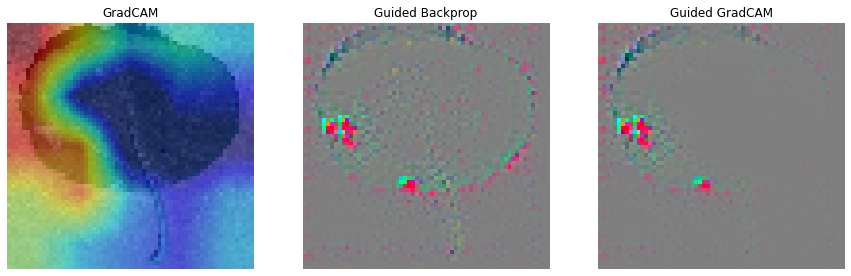

In [ ]:
""" This funtions computers Guided Grad-CAM
    as well as visualises all 3 approaches"""
def guided_gradcam_fn(model, guided_model, img_path, layer_name, cls=-1, visualize=True, save=True):
    preprocessed_input = load_image(img_path)
    predictions = model.predict(preprocessed_input)
    top = np.argmax(predictions)
    print('Model prediction: '+ mapping[top])
    print()
    print('Probabilities:')
    for i in range(4):
      print('\t{}. {}\t{:.3f}'.format(i, mapping[i], predictions[0,i]))
  
    if cls == -1:
        cls = np.argmax(predictions)
    print()
    print("Explanation for '{}':".format(mapping[cls]))
    print()
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

guided_model = build_guided_model()
plt.imshow(load_image(img_path, preprocess=False))

gradcam, gb, guided_gradcam = guided_gradcam_fn(model, guided_model, img_path, layer_name=last_conv_layer_name, 
                                               cls=-1, visualize=True, save=True)